In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from perm_test import pw_perm_kruskal_test
from statsmodels.stats.multitest import multipletests

## Import and reformat data

In [19]:
#import distance matrix, atchison no blanks
aitch = pd.read_csv('../data/SRS_aitchison_distance_matrix.tsv', sep='\t', index_col=0)

In [20]:
#melt distance matrix and convert to pandas dataframe 
meltaitch = aitch.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['col1','col2','distance']

# drop sample-sample distances that equal 0
df = df[df['col1']!=df['col2']]
# drop reverse duplicates
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
test = df.drop_duplicates('check_string')

In [21]:
#split sample names to break down comparisons, and merge into one dataframe
df1 = df.col1.str.split('.',expand=True)
df1.columns=['subj1','timepoint1','processing1']

df2 = df.col2.str.split('.',expand=True)
df2.columns=['subj2','timepoint2','processing2']

dff = pd.concat([df1, df2, df], axis=1)

#add in sample
dff['samp1'] = dff['col1'].str[0:4]
dff['samp2'] = dff['col2'].str[0:4]

#add in treatment group
dff['tx1'] = dff['samp1'].str[0:1]
dff['tx2'] = dff['samp2'].str[0:1]

#rename PMA-tx samples (left blank in sequencing name)
dff['processing1'].fillna(value='PMA', inplace=True)
dff['processing2'].fillna(value='PMA', inplace=True)

## Compare average distance within a given participant across treatments

In [46]:
# subset out distances among samples from the same subject processed the same way
ss = dff[(dff['subj1']==dff['subj2'])&(dff['processing1']==dff['processing2'])]
# rename treatments from variable code to desscription
ss['tx'] = ss['tx1'].replace({'A':'water','B':'antiseptic mw', 'C':'alcohol-free mw', 'D':'soda'})
ss['tx'].unique()

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array(['alcohol-free mw', 'water', 'antiseptic mw', 'soda'], dtype=object)

In [48]:
# Run bootstrapped kruskal-wallis test on samples from same individual processed  either
# with or without PMA
result = pw_perm_kruskal_test(ss['distance'],ss['processing1'])
print(result)

  Group1 Group2  Statistic      Pval
0    PMA    raw  86.245865  0.000999


In [49]:
# subset out samples procccesed with PMA versus raw
ssp = ss[(ss['processing1']==ss['processing2'])&
         (ss['processing1']=='PMA')]
ssr = ss[(ss['processing1']==ss['processing2'])&
         (ss['processing1']=='raw')]

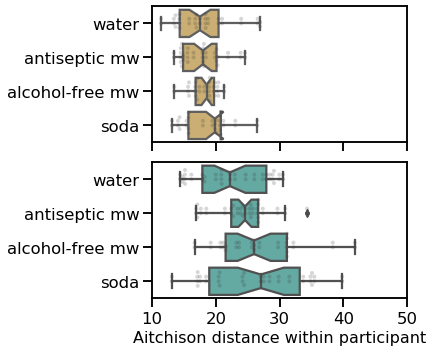

In [50]:
# plot
order=['water', 'antiseptic mw', 'alcohol-free mw', 'soda'] # choose order of txs
fig, (ax1, ax2) = plt.subplots(2, sharex=True) # make 2 side by side plots
fig.set_size_inches(6,5)
# plot data
sns.boxplot(y='tx',x='distance', data=ssr, palette=['#d8b365'], ax=ax1, order=order, notch=True)
sns.boxplot(y='tx',x='distance', data=ssp, ax=ax2, palette=['#5ab4ac'], order=order, notch=True)

sns.swarmplot(y='tx',x='distance', data=ssr, ax=ax1, order=order, color='.2', alpha=.2, size=4)
sns.swarmplot(y='tx',x='distance', data=ssp, ax=ax2, order=order, color='.2', alpha=.2, size=4)

# set labels 
ax1.set_xlabel('')
ax2.set_xlabel('Aitchison distance within participant', fontsize=16)
ax1.set_ylabel('')
ax2.set_ylabel('')
# adjust scale
ax1.set_xlim(10,50)
ax2.set_xlim(10,50)
plt.tight_layout()
# save
fig.savefig('/Users/lisamarotz/Dropbox/Lisa_stuff/Thesis/publications/Saliva_quant/Figures/Figure4_response/aitchison_dist_raw_v_PMA_v_tx.pdf',
            bbox_inches='tight')

In [51]:
# Run kruskal-wallis permutation test on raw ('total') data
result = pw_perm_kruskal_test(ssr['distance'], ssr['tx1'])
print(result)

  Group1 Group2  Statistic      Pval
0      A      C   0.379542  0.565435
1      B      C   0.966811  0.332667
2      B      A   0.008843  0.910090
3      D      C   1.162346  0.301698
4      D      A   0.824365  0.361638
5      D      B   1.169454  0.264735


In [52]:
# Run kruskal-wallis permutation test on PMA-treated ('live') data
result = pw_perm_kruskal_test(ssp['distance'], ssp['tx1'])
print(result)

  Group1 Group2  Statistic      Pval
0      D      C   0.147165  0.692308
1      B      C   2.589581  0.113886
2      B      D   1.474375  0.213786
3      A      C   8.683328  0.002997
4      A      D   4.095487  0.037962
5      A      B   1.898847  0.166833


## Identify timepoint driving variation in PMA-treated samples

In [31]:
# create function to label different distance types
def f(row):
    if ((row['timepoint1']!='3')&(row['timepoint2']!='3')):
           val = "t1-t2"
    elif ((row['timepoint1']!='2')&(row['timepoint2']!='2')):
           val = "t1-t3"
    else:
        val = "t2-t3"
    return val

ssr['cat2'] = ssr.apply(f, axis=1)
ssp['cat2'] = ssp.apply(f, axis=1)

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [32]:
# sort values for plotting below
ssp.sort_values(by='cat2', inplace=True)

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


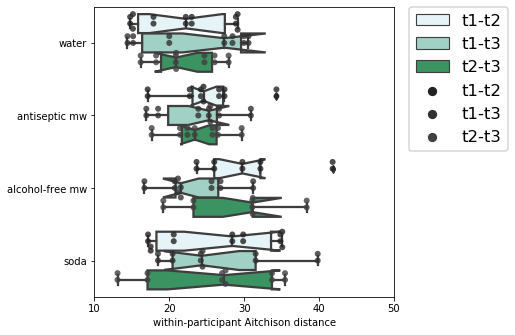

In [33]:
# plot
order=['water', 'antiseptic mw', 'alcohol-free mw', 'soda'] # choose order of txs
fig, ax1 = plt.subplots() # make 2 side by side plots
fig.set_size_inches(6,5)
sns.set_context('talk')
# plot data
sns.boxplot(y='tx',x='distance', data=ssp, ax=ax1, hue='cat2', palette=['#e5f5f9','#99d8c9','#2ca25f'],order=order, notch=True)
sns.swarmplot(y='tx',x='distance', data=ssp, ax=ax1, order=order, hue='cat2', color='.25',alpha='0.8', size=6, dodge=True)

# set labels 
ax1.set_ylabel('')
ax1.set_xlabel('within-participant Aitchison distance')
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
# adjust scale
ax1.set_xlim(10,50)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig('/Users/lisamarotz/Dropbox/Lisa_stuff/Thesis/publications/Saliva_quant/Figures/FigureS4_time_v_beta/Aitchison_distance_across_timepoints_by_group.pdf',
            bbox_inches='tight')

In [34]:
# divide up each of the 4 treatment groups for statistical analysis of beta-diversity across across timepoint
wp = ssp[ssp['tx']=='water']
asmp = ssp[ssp['tx']=='antiseptic mw']
afmp = ssp[ssp['tx']=='alcohol-free mw']
sp = ssp[ssp['tx']=='soda']

In [35]:
# Run kruskal-wallis permutation test in live beta-diversity across timepoints 
# in water treatment group
result = pw_perm_kruskal_test(wp['distance'], wp['cat2'])
print(result)

  Group1 Group2  Statistic      Pval
0  t1-t3  t1-t2   0.686656  0.383616
1  t2-t3  t1-t2   0.076295  0.734266
2  t2-t3  t1-t3   0.686656  0.416583


In [39]:
# Run kruskal-wallis permutation test in live beta-diversity across timepoints 
# in water antiseptic mouthwash group
result = pw_perm_kruskal_test(asmp['distance'], asmp['cat2'])
print(result)

  Group1 Group2  Statistic      Pval
0  t1-t3  t1-t2   0.211931  0.628372
1  t2-t3  t1-t2   1.025746  0.291708
2  t2-t3  t1-t3   0.076295  0.770230


In [40]:
# Run kruskal-wallis permutation test in live beta-diversity across timepoints 
# in alcohol-free mouthwash treatment group
result = pw_perm_kruskal_test(afmp['distance'], afmp['cat2'])
print(result)

  Group1 Group2  Statistic      Pval
0  t1-t3  t1-t2   7.292907  0.008991
1  t2-t3  t1-t2   0.575758  0.439560
2  t2-t3  t1-t3   2.329870  0.123876


In [41]:
# Run kruskal-wallis permutation test in live beta-diversity across timepoints 
# in soda treatment group
result = pw_perm_kruskal_test(sp['distance'], sp['cat2'])
print(result)

  Group1 Group2  Statistic      Pval
0  t1-t3  t1-t2   0.042517  0.796204
1  t2-t3  t1-t2   0.382653  0.511489
2  t2-t3  t1-t3   0.000000  0.959041
